In [60]:
from PIL import Image
import requests
from transformers import AutoProcessor, AutoModel
import torch

model = AutoModel.from_pretrained("google/siglip-base-patch16-224")
model.to('cuda')
model.half()
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224", device='cuda')

In [81]:
import polars as pl

df = pl.read_csv("../data/filtered/movies.csv")


In [ ]:
def get_image_features(image_id):
    try:
        img = Image.open(f"../data/filtered/posters/posters/{image_id}.jpg")
        inputs = processor(images=img, return_tensors="pt")
        inputs = {k: v.to('cuda') for k, v in inputs.items()}
        with torch.no_grad():
            image_features = model.get_image_features(**inputs)
        return image_features.cpu().numpy()[0]
    except Exception as e:
        print(f"Error processing image {image_id}: {e}")
        return [0] * 768

In [ ]:
from tqdm import tqdm
movie_ids = df['movie_id'].to_list()
all_embeddings = []
for movie_id in tqdm(movie_ids):
    embedding = get_image_features(movie_id)
    all_embeddings.append(embedding)

df = df.with_columns(
    pl.Series("image_embeddings", all_embeddings)
)

 55%|█████▌    | 5854/10599 [01:25<01:07, 69.99it/s]

Error processing image 5840: Unsupported number of image dimensions: 2


 62%|██████▏   | 6576/10599 [01:37<01:08, 58.63it/s]

Error processing image 6568: Unsupported number of image dimensions: 2


 64%|██████▎   | 6750/10599 [01:40<00:56, 68.11it/s]

Error processing image 6738: Unsupported number of image dimensions: 2


 69%|██████▉   | 7289/10599 [01:47<00:42, 77.32it/s]

Error processing image 7274: Unsupported number of image dimensions: 2


 73%|███████▎  | 7699/10599 [01:53<00:37, 78.15it/s]

Error processing image 7687: Unsupported number of image dimensions: 2


 76%|███████▌  | 8018/10599 [01:57<00:31, 80.76it/s]

Error processing image 8002: Unsupported number of image dimensions: 2


 80%|███████▉  | 8447/10599 [02:03<00:27, 79.33it/s]

Error processing image 8432: Unsupported number of image dimensions: 2


 81%|████████  | 8572/10599 [02:05<00:27, 74.74it/s]

Error processing image 8556: Unsupported number of image dimensions: 2
Error processing image 8558: Unsupported number of image dimensions: 2


 98%|█████████▊| 10396/10599 [02:34<00:03, 65.80it/s]

Error processing image 10386: Unsupported number of image dimensions: 2


100%|██████████| 10599/10599 [02:38<00:00, 67.05it/s]


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

class ImageMLP(nn.Module):
    def __init__(self, input_dim=768, hidden_dim=256, output_dim=1, dropout=0.1):
        super(ImageMLP, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        return self.layers(x)

class LogCoshLoss(nn.Module):
    """
    LogCosh loss function: log(cosh(y_pred - y_true))
    """
    def __init__(self):
        super(LogCoshLoss, self).__init__()
    
    def forward(self, y_pred, y_true):
        diff = y_pred - y_true
        return torch.mean(torch.log(torch.cosh(diff)))

class MovieDataset(Dataset):
    def __init__(self, embeddings, targets):
        self.embeddings = torch.FloatTensor(embeddings)
        self.targets = torch.FloatTensor(targets)
    
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.targets[idx]

def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=100, device='cuda'):
    model.to(device)
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for batch_embeddings, batch_targets in train_loader:
            batch_embeddings = batch_embeddings.to(device)
            batch_targets = batch_targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_embeddings)
            loss = loss_fn(outputs.squeeze(), batch_targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_embeddings, batch_targets in val_loader:
                batch_embeddings = batch_embeddings.to(device)
                batch_targets = batch_targets.to(device)
                
                outputs = model(batch_embeddings)
                loss = loss_fn(outputs.squeeze(), batch_targets)
                val_loss += loss.item()
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        if epoch % 10 == 0:
            print(f'Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    return train_losses, val_losses


In [ ]:
df_train = df.filter(pl.col('date') < 2015)
df_val = df.filter(pl.col('date') >= 2015)

X_train = df_train.select('image_embeddings').to_numpy()
y_train = df_train.select('rating').to_numpy()

X_val = df_val.select('image_embeddings').to_numpy()
y_val = df_val.select('rating').to_numpy()

In [ ]:
X_train = [x[0] for x in X_train]
X_val = [x[0] for x in X_val]

X_train = np.array(X_train)
X_val = np.array(X_val)

In [ ]:
train_dataset = MovieDataset(X_train, y_train)
val_dataset = MovieDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model_mse = ImageMLP(input_dim=768, hidden_dim=256, output_dim=1)
model_logcosh = ImageMLP(input_dim=768, hidden_dim=256, output_dim=1)

mse_loss = nn.MSELoss()
logcosh_loss = LogCoshLoss()

optimizer_mse = optim.Adam(model_mse.parameters(), lr=0.001)
optimizer_logcosh = optim.Adam(model_logcosh.parameters(), lr=0.001)

print("Training model with MSE loss...")
train_losses_mse, val_losses_mse = train_model(
    model_mse, train_loader, val_loader, mse_loss, optimizer_mse, num_epochs=10
)

print("\nTraining model with LogCosh loss...")
train_losses_logcosh, val_losses_logcosh = train_model(
    model_logcosh, train_loader, val_loader, logcosh_loss, optimizer_logcosh, num_epochs=10
)


Training model with MSE loss...


/opt/conda/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([6, 1])) that is different to the input size (torch.Size([6])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, targ

Epoch 0/10, Train Loss: 0.3696, Val Loss: 0.4105

Training model with LogCosh loss...
Epoch 0/10, Train Loss: 0.1383, Val Loss: 0.2123


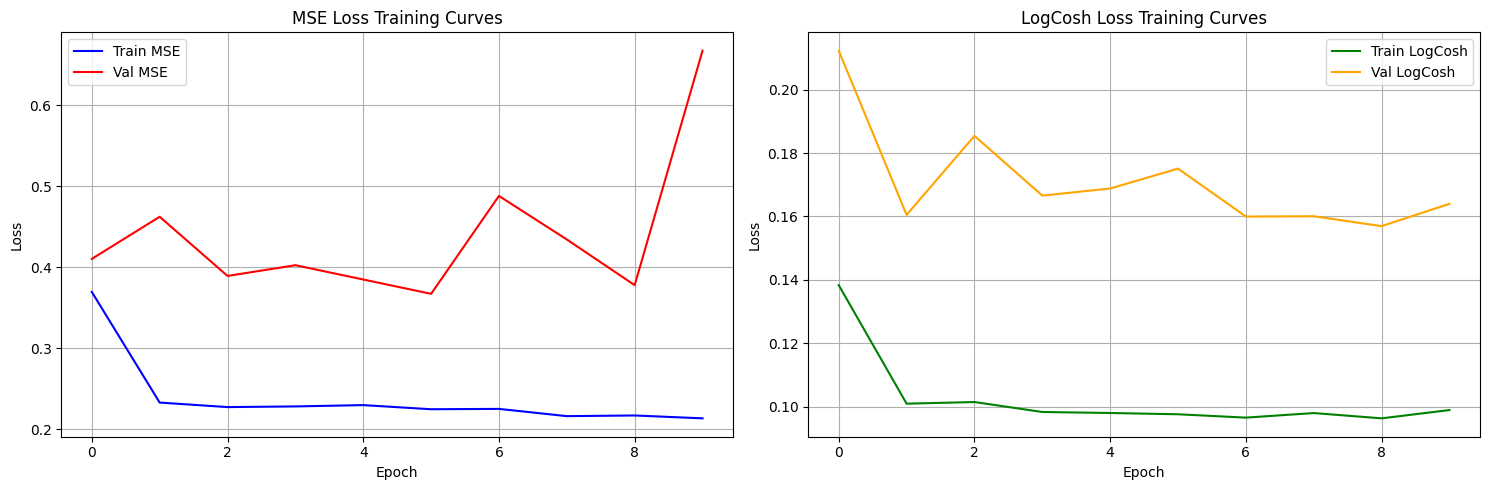

Final MSE - Train: 0.2134, Val: 0.6677
Final LogCosh - Train: 0.0990, Val: 0.1640

MSE Model - RMSE: 0.8256, MAE: 0.6712
LogCosh Model - RMSE: 0.6101, MAE: 0.4974


In [ ]:
# Plot training curves for both loss functions
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses_mse, label='Train MSE', color='blue')
plt.plot(val_losses_mse, label='Val MSE', color='red')
plt.title('MSE Loss Training Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_losses_logcosh, label='Train LogCosh', color='green')
plt.plot(val_losses_logcosh, label='Val LogCosh', color='orange')
plt.title('LogCosh Loss Training Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Compare final losses
print(f"Final MSE - Train: {train_losses_mse[-1]:.4f}, Val: {val_losses_mse[-1]:.4f}")
print(f"Final LogCosh - Train: {train_losses_logcosh[-1]:.4f}, Val: {val_losses_logcosh[-1]:.4f}")

# Function to make predictions
def predict(model, data_loader, device='cuda'):
    model.eval()
    predictions = []
    targets = []
    
    with torch.no_grad():
        for batch_embeddings, batch_targets in data_loader:
            batch_embeddings = batch_embeddings.to(device)
            outputs = model(batch_embeddings)
            predictions.extend(outputs.cpu().numpy().flatten())
            targets.extend(batch_targets.numpy())
    
    return np.array(predictions), np.array(targets)

pred_mse, true_vals = predict(model_mse, val_loader)
pred_logcosh, _ = predict(model_logcosh, val_loader)

rmse_mse = np.sqrt(mean_squared_error(true_vals, pred_mse))
mae_mse = mean_absolute_error(true_vals, pred_mse)

rmse_logcosh = np.sqrt(mean_squared_error(true_vals, pred_logcosh))
mae_logcosh = mean_absolute_error(true_vals, pred_logcosh)

print(f"\nMSE Model - RMSE: {rmse_mse:.4f}, MAE: {mae_mse:.4f}")
print(f"LogCosh Model - RMSE: {rmse_logcosh:.4f}, MAE: {mae_logcosh:.4f}")


In [79]:
print(f" min {min(pred_logcosh)}:  max {max(pred_logcosh)}, variance {np.var(pred_logcosh)}") 

 min 1.3877702951431274:  max 3.427647352218628, variance 0.011825237423181534


In [80]:
print(f" min {min(pred_mse)}:  max {max(pred_mse)}, variance {np.var(pred_mse)}") 

 min 1.6877855062484741:  max 3.825334310531616, variance 0.01526169665157795


In [71]:
df_val = df_val.with_columns(pl.Series('predicted_rating', pred_logcosh))
df_val2 = df_val.head(10)
df_val2.select('name', 'date', 'rating', 'predicted_rating')

name,date,rating,predicted_rating
str,i64,f64,f32
"""Barbie""",2023,3.86,3.194367
"""Oppenheimer""",2023,4.23,2.938808
"""Joker""",2019,3.85,3.064062
"""Spider-Man: Into the Spider-Ve…",2018,4.42,3.051317
"""The Batman""",2022,3.98,3.026004
"""Knives Out""",2019,3.99,3.118635
"""Poor Things""",2023,4.05,3.212318
"""Spider-Man: Across the Spider-…",2023,4.45,3.108598
"""Spider-Man: No Way Home""",2021,3.84,3.141064


In [77]:
df_val.filter(pl.col('rating') < 2.3).select('name', 'date', 'rating', 'predicted_rating')

name,date,rating,predicted_rating
str,i64,f64,f32
"""Suicide Squad""",2016,2.06,3.111373
"""Wonder Woman 1984""",2020,2.09,3.068365
"""Jurassic World Dominion""",2022,2.2,3.016683
"""Madame Web""",2024,1.49,3.155819
"""Morbius""",2022,1.6,2.959253
…,…,…,…
"""Homeward""",2020,2.28,3.074823
"""Survive the Game""",2021,2.26,2.97062
"""Natural Born Pranksters""",2016,2.17,2.97852


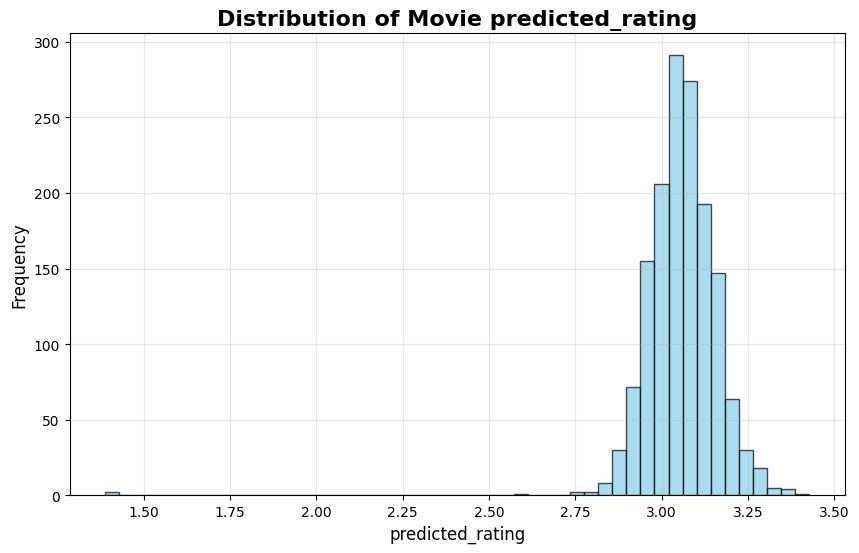

In [78]:
import matplotlib.pyplot as plt
import numpy as np

def plot_distribution(df, column):
    target_column = df[column].to_numpy()

    plt.figure(figsize=(10, 6))
    plt.hist(target_column, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of Movie {column}', fontsize=16, fontweight='bold')
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, alpha=0.3)
plot_distribution(df_val, 'predicted_rating')

## Conclusion:
low variance and generalization

##  Checking Linear regression on top of embeddings just for comparing with text embeddings

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.metrics import mean_squared_error


models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=0.1),
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    mae = mean_absolute_error(y_val, y_pred)
    print(f"{model_name} RMSE: {rmse}, MAE: {mae}")

Linear Regression RMSE: 0.5357476122549074, MAE: 0.41909199479034714
Ridge Regression RMSE: 0.5356714880937727, MAE: 0.41902905649891437
